# **Multilabel classification**

Multiclass classification makes the assumption that each sample is assigned to one and only one label: a fruit can be either an apple or a pear but not both at the same time.

Multilabel classification assigns to each sample a set of target labels.



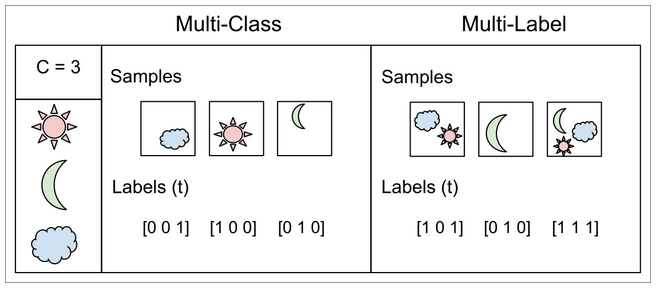

# Import Libraries

In [ ]:
!pip install tensorflow-gpu==2.0.0-rc0

In [2]:
import os, pickle, shutil, glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.backend as K
import time, random, copy
import imageio

from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, precision_recall_curve, confusion_matrix, average_precision_score
import seaborn as sns
from skimage.transform import rotate, AffineTransform, warp, resize
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPool2D, GlobalAveragePooling2D, Input
from tensorflow.keras.layers import Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import Sequence

from tqdm import tqdm

# example of loading the resnet50 model
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint


%matplotlib inline

In [3]:
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile

In [4]:
tf.test.is_gpu_available()

True

# Paths to Data Directories

In [5]:
# Check if NVIDIA GPU is enabled
!nvidia-smi

Wed Sep 29 02:49:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    60W / 149W |     60MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
BASE       = '/content'
DATA_PATH  = os.path.join( BASE, 'data')
IMG_DIR    = os.path.join( DATA_PATH, 'images' )

In [7]:
if not os.path.exists(DATA_PATH):
  os.mkdir(DATA_PATH)

if not os.path.exists(IMG_DIR):
  os.mkdir(IMG_DIR)

# Data

In [8]:
def tree_printer(root):
  for root, dirs, files in os.walk(root):
    for d in dirs:
      print( os.path.join(root, d) )
    # for f in files:
    #   print(os.path.join(root, f))
tree_printer(DATA_PATH)

/content/data/images


In [9]:
def download_and_unzip(url, extract_to='.'):
  http_response = urlopen(url)
  zipfile = ZipFile(BytesIO(http_response.read()))
  zipfile.extractall(path=extract_to)

Dataset (images)

In [10]:
movie_poster_url = 'https://www.cs.ccu.edu.tw/~wtchu/projects/MoviePoster/Movie_Poster_Dataset.zip'
download_and_unzip(movie_poster_url, extract_to=DATA_PATH)

In [11]:
DATA_DIR = os.path.join(DATA_PATH, 'Movie_Poster_Dataset')
META_DATA_DIR = os.path.join(DATA_PATH, 'groundtruth')
print('DATA_DIR : ', DATA_DIR)
print('META_DATA_DIR : ', META_DATA_DIR)

DATA_DIR :  /content/data/Movie_Poster_Dataset
META_DATA_DIR :  /content/data/groundtruth


In [12]:
folders = glob.glob(DATA_DIR+'/*')
print(len(folders))
folders[:3]

36


['/content/data/Movie_Poster_Dataset/2010',
 '/content/data/Movie_Poster_Dataset/2000',
 '/content/data/Movie_Poster_Dataset/1996']

In [13]:
# Copy all images to /data/images
for i,folder in enumerate(folders):
  files = glob.glob(folder + '/*.jpg')
  if len(files) == 0:
    continue
  
  for filepath in files:
    shutil.move(filepath, IMG_DIR)

In [14]:
% pwd
% rm -rf /content/data/Movie_Poster_Dataset/

In [15]:
all_images = glob.glob(IMG_DIR + '/*.jpg')
len(all_images)

8052

In [16]:
# Read metadata to get Y values (multiple lables)
df = pd.read_csv( os.path.join(DATA_PATH, 'multi_hot_labels.csv') )
df['imdbID'] = df['imdbID'].apply( lambda x: IMG_DIR + '/' + x + '.jpg' )
df.head()

,imdbID,Genre,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Music,Musical,Mystery,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
0,/content/data/images/tt0086960.jpg,"Action, Comedy, Crime",1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,/content/data/images/tt0087332.jpg,"Adventure, Comedy, Fantasy",0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,/content/data/images/tt0087469.jpg,"Action, Adventure",1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,/content/data/images/tt0087363.jpg,"Comedy, Fantasy, Horror",0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,/content/data/images/tt0087538.jpg,"Action, Drama, Family",1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [17]:
df.shape

(8041, 26)

In [18]:
df['Genre'] = df['Genre'].apply(lambda x: x.replace(' ', ''))
df['Genre']

0            Action,Comedy,Crime
1       Adventure,Comedy,Fantasy
2               Action,Adventure
3          Comedy,Fantasy,Horror
4            Action,Drama,Family
                  ...           
8036        Comedy,Drama,Romance
8037                      Comedy
8038         Documentary,History
8039                       Drama
8040           Documentary,Music
Name: Genre, Length: 8041, dtype: object

In [19]:
len(df['imdbID'].unique())

8041

In [20]:
# df = df.iloc[:4000]
print(len(df.columns))
print(df.columns)

26
Index(['imdbID', 'Genre', 'Action', 'Adventure', 'Animation', 'Biography',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy',
       'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News',
       'Reality-TV', 'Romance', 'Sci-Fi', 'Short', 'Sport', 'Thriller', 'War',
       'Western'],
      dtype='object')


Number of Genres: 24


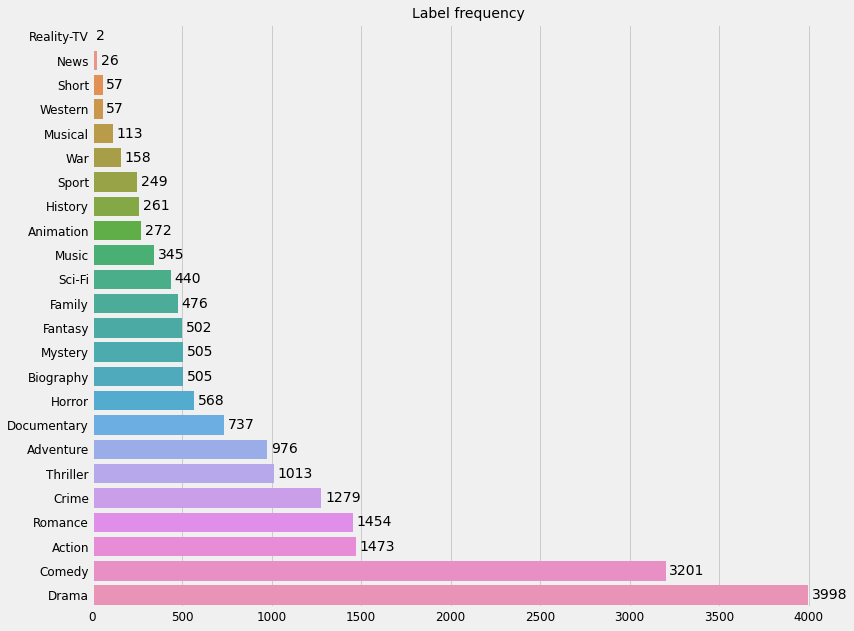

In [21]:
# Get label frequencies in descending order
label_freq = df['Genre'].apply(lambda s: str(s).split(',') ).explode().value_counts().sort_values(ascending=True)
print('Number of Genres:', len(label_freq))

# Bar plot
plt.style.use("fivethirtyeight")
plt.figure(figsize=(12,10))


ax = sns.barplot(y=label_freq.index.values, x=label_freq, order=label_freq.index)

for p in ax.patches:
  width = p.get_width()    # get bar length
  ax.text(width + 20,       # set the text at 20 unit right of the bar
    p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
    '{:1.0f}'.format(width), # set variable to display, 2 decimals
    ha = 'left',   # horizontal alignment
    va = 'center')  # vertical alignment


plt.title("Label frequency", fontsize=14)
plt.xlabel("")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Remove infrequent labels

We will consider as a rare label every label that is covered by less than 1000 posters in our dataset.
We will assume that these labels are very hard to predict due to lack of sufficient data.
The model that we will train later will not focus on predicting these labels.
So, we need to make some transformation in the label column (Genre) where we ignore infrequent labels by hiding them.

In [22]:
# Create a list of rare labels
rare = list(label_freq[label_freq<150].index)
print("Ignore rare labels:", rare)

Ignore rare labels: ['Reality-TV', 'News', 'Short', 'Western', 'Musical']


In [23]:
# Transform Genre into a list of labels and remove the rare ones
df['GenreList'] = df['Genre'].apply(lambda s: [l for l in str(s).split(',') if l not in rare])
df.head(2)

,imdbID,Genre,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Music,Musical,Mystery,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Thriller,War,Western,GenreList
0,/content/data/images/tt0086960.jpg,"Action,Comedy,Crime",1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"[Action, Comedy, Crime]"
1,/content/data/images/tt0087332.jpg,"Adventure,Comedy,Fantasy",0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"[Adventure, Comedy, Fantasy]"


In [24]:
df = df[ ['imdbID', 'Genre', 'GenreList', 'Action', 'Adventure', 'Animation', 'Biography',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy',
       'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News',
       'Reality-TV', 'Romance', 'Sci-Fi', 'Short', 'Sport', 'Thriller', 'War',
       'Western'] ]

In [25]:
df.head(2)

,imdbID,Genre,GenreList,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Music,Musical,Mystery,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
0,/content/data/images/tt0086960.jpg,"Action,Comedy,Crime","[Action, Comedy, Crime]",1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,/content/data/images/tt0087332.jpg,"Adventure,Comedy,Fantasy","[Adventure, Comedy, Fantasy]",0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [26]:
df = df.drop( rare, axis=1 )
print('Columns: ', df.columns)
print('Number of labels: ', len(df.columns) - 3)
df.head()

Columns:  Index(['imdbID', 'Genre', 'GenreList', 'Action', 'Adventure', 'Animation',
       'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family',
       'Fantasy', 'History', 'Horror', 'Music', 'Mystery', 'Romance', 'Sci-Fi',
       'Sport', 'Thriller', 'War'],
      dtype='object')
Number of labels:  19


,imdbID,Genre,GenreList,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Music,Mystery,Romance,Sci-Fi,Sport,Thriller,War
0,/content/data/images/tt0086960.jpg,"Action,Comedy,Crime","[Action, Comedy, Crime]",1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,/content/data/images/tt0087332.jpg,"Adventure,Comedy,Fantasy","[Adventure, Comedy, Fantasy]",0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,/content/data/images/tt0087469.jpg,"Action,Adventure","[Action, Adventure]",1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,/content/data/images/tt0087363.jpg,"Comedy,Fantasy,Horror","[Comedy, Fantasy, Horror]",0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0
4,/content/data/images/tt0087538.jpg,"Action,Drama,Family","[Action, Drama, Family]",1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0


Number of Genres:  19


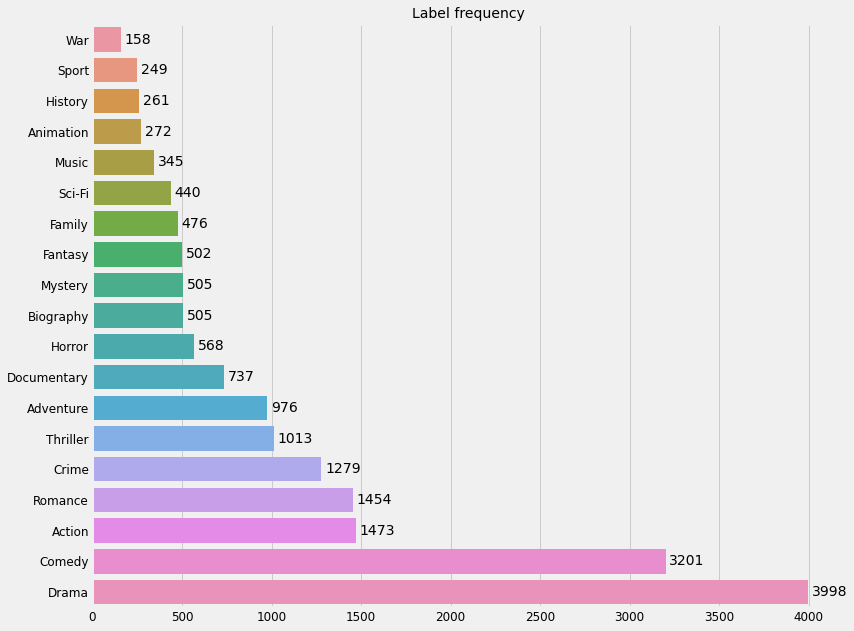

In [27]:
# Get label frequencies in descending order
# label_freq = df['Genre'].apply(lambda s: str(s).split(',') ).explode().value_counts().sort_values(ascending=False)
label_freq = df['GenreList'].explode().value_counts().sort_values(ascending=True)
print('Number of Genres: ', len(label_freq))

# Bar plot
plt.style.use("fivethirtyeight")
plt.figure(figsize=(12,10))


ax = sns.barplot(y=label_freq.index.values, x=label_freq, order=label_freq.index)

for p in ax.patches:
  width = p.get_width()    # get bar length
  ax.text(width + 20,       # set the text at 20 unit right of the bar
    p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
    '{:1.0f}'.format(width), # set variable to display, 2 decimals
    ha = 'left',   # horizontal alignment
    va = 'center')  # vertical alignment


plt.title("Label frequency", fontsize=14)
plt.xlabel("")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [28]:
print(label_freq)
print(label_freq['Sport'])
print(label_freq['Drama'])
print(label_freq.sum())
print(label_freq.index)
print(label_freq.values)

War             158
Sport           249
History         261
Animation       272
Music           345
Sci-Fi          440
Family          476
Fantasy         502
Mystery         505
Biography       505
Horror          568
Documentary     737
Adventure       976
Thriller       1013
Crime          1279
Romance        1454
Action         1473
Comedy         3201
Drama          3998
Name: GenreList, dtype: int64
249
3998
18412
Index(['War', 'Sport', 'History', 'Animation', 'Music', 'Sci-Fi', 'Family',
       'Fantasy', 'Mystery', 'Biography', 'Horror', 'Documentary', 'Adventure',
       'Thriller', 'Crime', 'Romance', 'Action', 'Comedy', 'Drama'],
      dtype='object')
[ 158  249  261  272  345  440  476  502  505  505  568  737  976 1013
 1279 1454 1473 3201 3998]


In [29]:
df = df.drop( ['Genre'], axis=1 )
print('Columns: ', df.columns)
print('Number of labels: ', len(df.columns) - 2)
df.head()

Columns:  Index(['imdbID', 'GenreList', 'Action', 'Adventure', 'Animation', 'Biography',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy',
       'History', 'Horror', 'Music', 'Mystery', 'Romance', 'Sci-Fi', 'Sport',
       'Thriller', 'War'],
      dtype='object')
Number of labels:  19


,imdbID,GenreList,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Music,Mystery,Romance,Sci-Fi,Sport,Thriller,War
0,/content/data/images/tt0086960.jpg,"[Action, Comedy, Crime]",1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,/content/data/images/tt0087332.jpg,"[Adventure, Comedy, Fantasy]",0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,/content/data/images/tt0087469.jpg,"[Action, Adventure]",1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,/content/data/images/tt0087363.jpg,"[Comedy, Fantasy, Horror]",0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0
4,/content/data/images/tt0087538.jpg,"[Action, Drama, Family]",1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0


In [30]:
df = df.drop( ['GenreList'], axis=1 )
print('Columns: ', df.columns)
print('Number of labels: ', len(df.columns) - 1)
df.head()

Columns:  Index(['imdbID', 'Action', 'Adventure', 'Animation', 'Biography', 'Comedy',
       'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'History',
       'Horror', 'Music', 'Mystery', 'Romance', 'Sci-Fi', 'Sport', 'Thriller',
       'War'],
      dtype='object')
Number of labels:  19


,imdbID,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Music,Mystery,Romance,Sci-Fi,Sport,Thriller,War
0,/content/data/images/tt0086960.jpg,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,/content/data/images/tt0087332.jpg,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,/content/data/images/tt0087469.jpg,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,/content/data/images/tt0087363.jpg,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0
4,/content/data/images/tt0087538.jpg,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0


In [31]:
class_names = df.columns[1:]
n_labels = len(class_names)
print('Number of labels: ', n_labels)
class_names

Number of labels:  19


Index(['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror',
       'Music', 'Mystery', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War'],
      dtype='object')

In [32]:
# Id and Genre are not labels to be trained. So drop them from the dataframe.
# No need to convert to categorical as the dataset is already in the right format.
y = df.drop(['imdbID'], axis=1)
y = y.to_numpy()
y.shape

(8041, 19)

In [33]:
X_files = df['imdbID']
print(X_files.shape)
X_files[0]

(8041,)


'/content/data/images/tt0086960.jpg'

In [34]:
del df

# Imbalanced Classes

In [35]:
label_freq_df = label_freq.to_frame(name='freq').reset_index()
label_freq_df.rename(columns={'index': 'labels'}, inplace=True)
label_freq_df

,labels,freq
0,War,158
1,Sport,249
2,History,261
3,Animation,272
4,Music,345
5,Sci-Fi,440
6,Family,476
7,Fantasy,502
8,Mystery,505
9,Biography,505


In [36]:
print(label_freq_df['freq'].sum())
print(label_freq_df.index)
# print(label_freq_df.values)
print(label_freq_df.loc[1])

18412
RangeIndex(start=0, stop=19, step=1)
labels    Sport
freq        249
Name: 1, dtype: object


Some labels occur more often than others, thus the classes are not well balanced. The imbalanced class problem can be addressed by applying class weights, thus weighting less frequent labels higher than very frequent labels.

In [146]:
label_freq_df['class_weight'] = (label_freq_df['freq'].max() / label_freq_df['freq'])**1.4
label_freq_df

,labels,freq,class_weight
0,War,158,92.142498
1,Sport,249,48.741717
2,History,261,45.633439
3,Animation,272,43.070850
4,Music,345,30.876863
5,Sci-Fi,440,21.965756
6,Family,476,19.675699
7,Fantasy,502,18.263950
8,Mystery,505,18.112232
9,Biography,505,18.112232


In [147]:
class_weight = {}
for index, label in enumerate(label_freq_df['labels']):
    class_weight[index] = label_freq_df.loc[index]['class_weight']

class_weight

{0: 92.14249844120455,
 1: 48.74171654759358,
 2: 45.63343861897438,
 3: 43.07084974520158,
 4: 30.876863124491074,
 5: 21.965756179655994,
 6: 19.675699082031453,
 7: 18.263949669755753,
 8: 18.112232162520424,
 9: 18.112232162520424,
 10: 15.363573261473086,
 11: 10.669041948564296,
 12: 7.200292859361691,
 13: 6.834813714343052,
 14: 4.9312968138707225,
 15: 4.120877803434573,
 16: 4.046653883564524,
 17: 1.3651487064081418,
 18: 1.0}

# Read image data

In [100]:
from tensorflow.keras.preprocessing import image

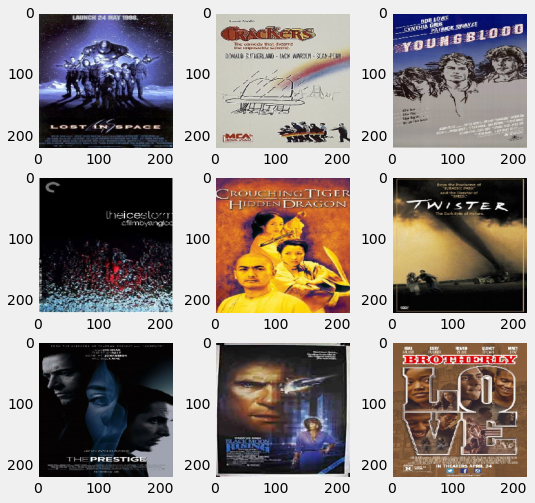

In [101]:
fig, axs = plt.subplots(3, 3, figsize=(8,8))
axs = axs.flatten()

SIZE = 224
for i in range(9):
  ax = axs[i]
  img = image.load_img(all_images[i], target_size=(SIZE, SIZE, 3))

  img = image.img_to_array(img)
  img = img/255.

  ax.grid(False)

  ax.imshow(img)

plt.show()

In [ ]:
# Read images using the IDs from metadata.
# Otherwise, the images may not correspond to the metadata from the csv file. 

SIZE = 224
X_dataset = []  
for i in tqdm(range(X_files.shape[0])):
  img = image.load_img(X_files[i], target_size=(SIZE, SIZE, 3))
  img = image.img_to_array(img)
  img = img/255.
  X_dataset.append(img)
    
X = np.array(X_dataset)

In [ ]:
del X_dataset

In [ ]:
X.shape

In [ ]:
del X_files

# CNN model

In [ ]:
# Training and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25)

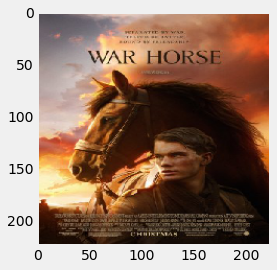

In [104]:
# Check
plt.imshow(X_test[2])
plt.grid(False)
plt.show()

In [ ]:
del X
del y

Read this paper for Multilabel Classification

https://www.depends-on-the-definition.com/guide-to-multi-label-classification-with-neural-networks/

https://wandb.ai/ayush-thakur/dl-question-bank/reports/How-to-do-multilabel-classification-using-Keras---VmlldzoyMDgyMDU


https://www.analyticsvidhya.com/blog/2019/04/build-first-multi-label-image-classification-model-python/

https://github.com/karanaryan07/multi-label-Movies-Poster-Classification-using-CNN/blob/master/MovieProject.ipynb

In [148]:
# Build CNN model
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(5, 5), activation='relu', input_shape=(SIZE,SIZE,3)))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.3))

model.add(Conv2D(32, (5,5), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.3))

model.add(Conv2D(64, (5,5), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.4))

model.add(Conv2D(128, (5,5), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.5))


model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))


model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))


model.add(Dense(n_labels, activation='sigmoid'))

# Do not use softmax for multilabel classification
# Softmax is useful for mutually exclusive classes, either cat or dog but not both.
# Also, softmax outputs all add to 1. So good for multi class problems where each
# class is given a probability and all add to 1. Highest one wins. 

# Sigmoid outputs probability. Can be used for non-mutually exclusive problems.
# like multi label, in this example.
# But, also good for binary mutually exclusive (cat or not cat). 

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 220, 220, 16)      1216      
_________________________________________________________________
batch_normalization_12 (Batc (None, 220, 220, 16)      64        
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 110, 110, 16)      0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 110, 110, 16)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 106, 106, 32)      12832     
_________________________________________________________________
batch_normalization_13 (Batc (None, 106, 106, 32)      128       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 53, 53, 32)       

In [149]:
# Now, compile the model. I’ll use binary_crossentropy as the loss function and ADAM as the optimizer
# (again, you can use other optimizers as well). 'adam' 'rmsprop
# opt = SGD(learning_rate=0.001)

#Binary cross entropy of each label. So no really a binary classification problem but
#Calculating binary cross entropy for each label. 
# model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model

In [151]:
# history = model.fit(...)
model.fit(X_train, y_train,
          class_weight=class_weight,
          epochs=25,
          validation_data=(X_test, y_test),
          batch_size=128)

Train on 6030 samples, validate on 2011 samples
Epoch 1/25
6030/6030 [==============================] - 18s 3ms/sample - loss: 30.0165 - accuracy: 0.5813 - val_loss: 24.9679 - val_accuracy: 0.7292
Epoch 2/25
6030/6030 [==============================] - 17s 3ms/sample - loss: 24.9133 - accuracy: 0.6756 - val_loss: 23.0575 - val_accuracy: 0.7598
Epoch 3/25
6030/6030 [==============================] - 17s 3ms/sample - loss: 19.5982 - accuracy: 0.7822 - val_loss: 16.6168 - val_accuracy: 0.8756
Epoch 4/25
6030/6030 [==============================] - 17s 3ms/sample - loss: 15.7849 - accuracy: 0.8429 - val_loss: 14.1052 - val_accuracy: 0.8793
Epoch 5/25
6030/6030 [==============================] - 17s 3ms/sample - loss: 14.1783 - accuracy: 0.8629 - val_loss: 15.8704 - val_accuracy: 0.8790
Epoch 6/25
6030/6030 [==============================] - 17s 3ms/sample - loss: 13.5606 - accuracy: 0.8680 - val_loss: 15.3426 - val_accuracy: 0.8728
Epoch 7/25
6030/6030 [==============================] - 17

In [152]:
history = model.history

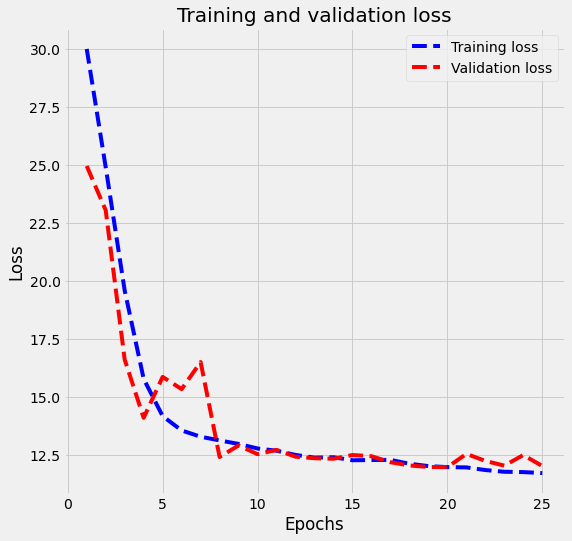

In [153]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)



plt.figure(figsize=(8,8))

plt.plot(epochs, loss, 'b--', label='Training loss')
plt.plot(epochs, val_loss, 'r--', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

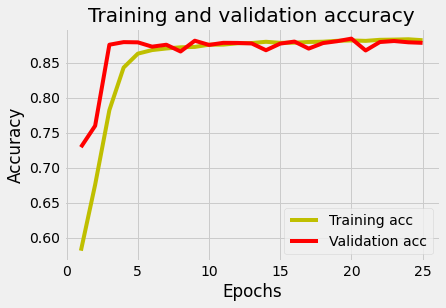

In [154]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']


plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Prediction

In [157]:
class_names = class_names.to_numpy()
class_names

array(['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror',
       'Music', 'Mystery', 'Romance', 'Sci-Fi', 'Sport', 'Thriller',
       'War'], dtype='<U11')

## Poster 1

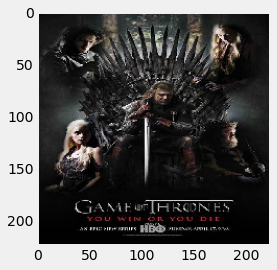

In [158]:
img = image.load_img(DATA_PATH + '/GOT2.jpg',target_size=(SIZE, SIZE, 3))
img = image.img_to_array(img)
img = img/255

plt.imshow(img)
plt.grid(False)
plt.show()

Now, we will predict the genre for these posters using our trained model. The model will tell us the probability for each genre and we will take the top 3 predictions from that.

In [159]:
# Reshape the image into Batch style [batch, Size, Size, channel]
img = img.reshape(1,SIZE,SIZE,3)

In [160]:
# Probability of each label
predicted_prob = model.predict(img)
predicted_prob

array([[0.78940034, 0.5647283 , 0.0525074 , 0.02229667, 0.09258902,
        0.14466083, 0.02519113, 0.20736194, 0.03191879, 0.18912011,
        0.0093247 , 0.12873638, 0.01709437, 0.05746502, 0.02314001,
        0.35495377, 0.00708704, 0.16286638, 0.00334983]], dtype=float32)

In [161]:
# Sort the predicted_probability (decending order) and take the indexes
indexes = np.argsort(predicted_prob[0])[::-1]
predicted_prob[0][indexes]

# All labels with decending order of probability
class_names[indexes]

# Top 5
class_names[indexes][:5]

array(['Action', 'Adventure', 'Sci-Fi', 'Drama', 'Fantasy'], dtype='<U11')

## Poster 2

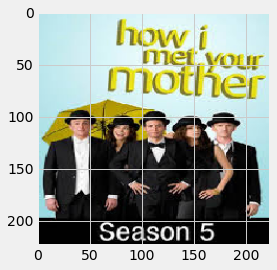

In [162]:
img = image.load_img(DATA_PATH + '/mm.jpg',target_size=(SIZE, SIZE, 3))
img = image.img_to_array(img)
img = img/255

plt.imshow(img)
plt.show()

Now, we will predict the genre for these posters using our trained model. The model will tell us the probability for each genre and we will take the top 3 predictions from that.

In [163]:
# Reshape the image into Batch style [batch, Size, Size, channel]
img = img.reshape(1,SIZE,SIZE,3)

In [164]:
# Probability of each label
predicted_prob = model.predict(img)
predicted_prob

array([[0.27962518, 0.34311634, 0.06271106, 0.03342447, 0.6405232 ,
        0.09200072, 0.02889416, 0.32831737, 0.11207345, 0.07162255,
        0.01037359, 0.01291081, 0.0127781 , 0.01648381, 0.12220362,
        0.03075278, 0.02123462, 0.02270884, 0.00542847]], dtype=float32)

In [165]:
# Sort the predicted_probability (decending order) and take the indexes
indexes = np.argsort(predicted_prob[0])[::-1]
predicted_prob[0][indexes]

# All labels with decending order of probability
class_names[indexes]

# Top 5
class_names[indexes][:5]

array(['Comedy', 'Adventure', 'Drama', 'Action', 'Romance'], dtype='<U11')

## Poster 3

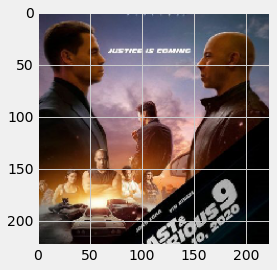

In [166]:
img = image.load_img(DATA_PATH + '/FF.jpg',target_size=(SIZE, SIZE, 3))
img = image.img_to_array(img)
img = img/255

plt.imshow(img)
plt.show()

Now, we will predict the genre for these posters using our trained model. The model will tell us the probability for each genre and we will take the top 3 predictions from that.

In [167]:
# Reshape the image into Batch style [batch, Size, Size, channel]
img = img.reshape(1,SIZE,SIZE,3)

In [168]:
# Probability of each label
predicted_prob = model.predict(img)
predicted_prob

array([[0.4057742 , 0.33128065, 0.04287162, 0.11376059, 0.2349852 ,
        0.13879111, 0.06570214, 0.533564  , 0.07659897, 0.12275499,
        0.04186913, 0.06285945, 0.02558422, 0.07235563, 0.14634112,
        0.11156499, 0.03272996, 0.12082613, 0.01842833]], dtype=float32)

In [169]:
# Sort the predicted_probability (decending order) and take the indexes
indexes = np.argsort(predicted_prob[0])[::-1]
predicted_prob[0][indexes]

# All labels with decending order of probability
class_names[indexes]

# Top 5
class_names[indexes][:5]

array(['Drama', 'Action', 'Adventure', 'Comedy', 'Romance'], dtype='<U11')

## Poster 3

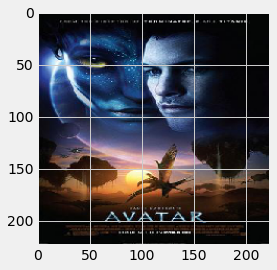

In [170]:
img = image.load_img(DATA_PATH + '/Avatar.jpg',target_size=(SIZE, SIZE, 3))
img = image.img_to_array(img)
img = img/255

plt.imshow(img)
plt.show()

Now, we will predict the genre for these posters using our trained model. The model will tell us the probability for each genre and we will take the top 3 predictions from that.

In [171]:
# Reshape the image into Batch style [batch, Size, Size, channel]
img = img.reshape(1,SIZE,SIZE,3)

In [172]:
# Probability of each label
predicted_prob = model.predict(img)
predicted_prob

array([[0.65481985, 0.3869033 , 0.03029591, 0.05782679, 0.08659238,
        0.16526484, 0.0425792 , 0.3849074 , 0.02839753, 0.14182153,
        0.02170527, 0.13423762, 0.02571166, 0.07373795, 0.05071127,
        0.21948826, 0.01726917, 0.20110354, 0.0098208 ]], dtype=float32)

In [173]:
# Sort the predicted_probability (decending order) and take the indexes
indexes = np.argsort(predicted_prob[0])[::-1]
predicted_prob[0][indexes]

# All labels with decending order of probability
class_names[indexes]

# Top 5
class_names[indexes][:5]

array(['Action', 'Adventure', 'Drama', 'Sci-Fi', 'Thriller'], dtype='<U11')

## Poster 4

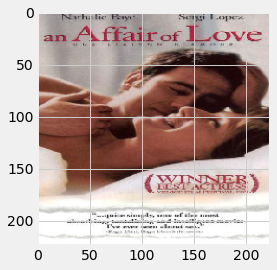

In [174]:
img = image.load_img(DATA_PATH + '/love.jpg',target_size=(SIZE, SIZE, 3))
img = image.img_to_array(img)
img = img/255

plt.imshow(img)
plt.show()

Now, we will predict the genre for these posters using our trained model. The model will tell us the probability for each genre and we will take the top 3 predictions from that.

In [175]:
# Reshape the image into Batch style [batch, Size, Size, channel]
img = img.reshape(1,SIZE,SIZE,3)

In [176]:
# Probability of each label
predicted_prob = model.predict(img)
predicted_prob

array([[0.1871615 , 0.10093006, 0.00457382, 0.12242621, 0.30786645,
        0.10922438, 0.03695926, 0.7418654 , 0.03713125, 0.04774463,
        0.04160458, 0.00885832, 0.00895289, 0.02802414, 0.30849016,
        0.01375803, 0.02236452, 0.07480311, 0.01287787]], dtype=float32)

In [177]:
# Sort the predicted_probability (decending order) and take the indexes
indexes = np.argsort(predicted_prob[0])[::-1]
predicted_prob[0][indexes]

# All labels with decending order of probability
class_names[indexes]

# Top 5
class_names[indexes][:5]

array(['Drama', 'Romance', 'Comedy', 'Action', 'Biography'], dtype='<U11')

## Poster 5

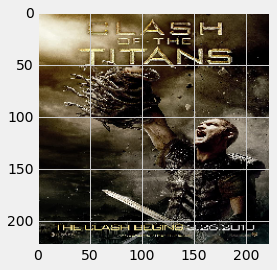

In [178]:
img = image.load_img(DATA_PATH + '/titans.jpg',target_size=(SIZE, SIZE, 3))
img = image.img_to_array(img)
img = img/255

plt.imshow(img)
plt.show()

Now, we will predict the genre for these posters using our trained model. The model will tell us the probability for each genre and we will take the top 3 predictions from that.

In [179]:
# Reshape the image into Batch style [batch, Size, Size, channel]
img = img.reshape(1,SIZE,SIZE,3)

In [180]:
# Probability of each label
predicted_prob = model.predict(img)
predicted_prob

array([[0.6199051 , 0.40398103, 0.06490558, 0.05061907, 0.24553823,
        0.16337812, 0.04614559, 0.33595976, 0.0645448 , 0.14163926,
        0.02054623, 0.08606553, 0.02556106, 0.05083007, 0.06602263,
        0.15717313, 0.02557333, 0.12560555, 0.01075894]], dtype=float32)

In [181]:
# Sort the predicted_probability (decending order) and take the indexes
indexes = np.argsort(predicted_prob[0])[::-1]
predicted_prob[0][indexes]

# All labels with decending order of probability
class_names[indexes]

# Top 5
class_names[indexes][:5]

array(['Action', 'Adventure', 'Drama', 'Comedy', 'Crime'], dtype='<U11')

# Save the model

In [182]:
# serialize model to JSON
model_json = model.to_json()
with open("model_classweight.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_classweight_weight.h5")
print("Saved model to disk")

Saved model to disk


In [183]:
# save the network to disk
print("Save the model...")
model.save("MultiLabelClassification_CNN_model_classweight.model", save_format="h5")

Save the model...


In [184]:
# # later...
 
# # load json and create model
# json_file = open('model.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# # load weights into new model
# loaded_model.load_weights("model.h5")
# print("Loaded model from disk")
 
# # evaluate loaded model on test data
# loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
# score = loaded_model.evaluate(X, Y, verbose=0)
# print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

In [ ]:
# Display all dependencies and their versions
!pip freeze